<a href="https://colab.research.google.com/github/oscarld-dl/ML-Workshop/blob/main/Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

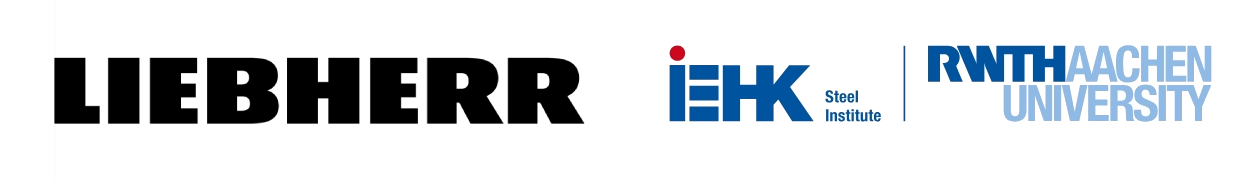

In [23]:
from IPython.display import Image, display
display(Image("head.jpg"))

# SciML Workshop

RWTH Aachen University, 07.10.2025




***************************************************************************************************************************
**The goal of this workshop is to understand how we have developed the descriptive and predictive analyses using ML/DL tools.**
***************************************************************************************************************************

**Tasks for the Predictive Analysis:**
-------------

1. Understanding **K-Fold Cross-Validation**.
2. Using **scikit.learn** to evaluate different **linear regression models**.
3. Upgrading to **stacked regression models** to improve accuracy.
4. Using the best performing model to **generate the outputs of new synthetic inputs** (after data augmentation)

**Import basic libraries again:**

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Import specific libraries:**

[Visit scikit-learn webpage HERE for more information](https://scikit-learn.org/stable/)

In [25]:
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, Lars, LassoLars, LassoLarsIC, BayesianRidge, MultiTaskLasso, MultiTaskLassoCV, HuberRegressor, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

**Understanding the Cross-Validation:**

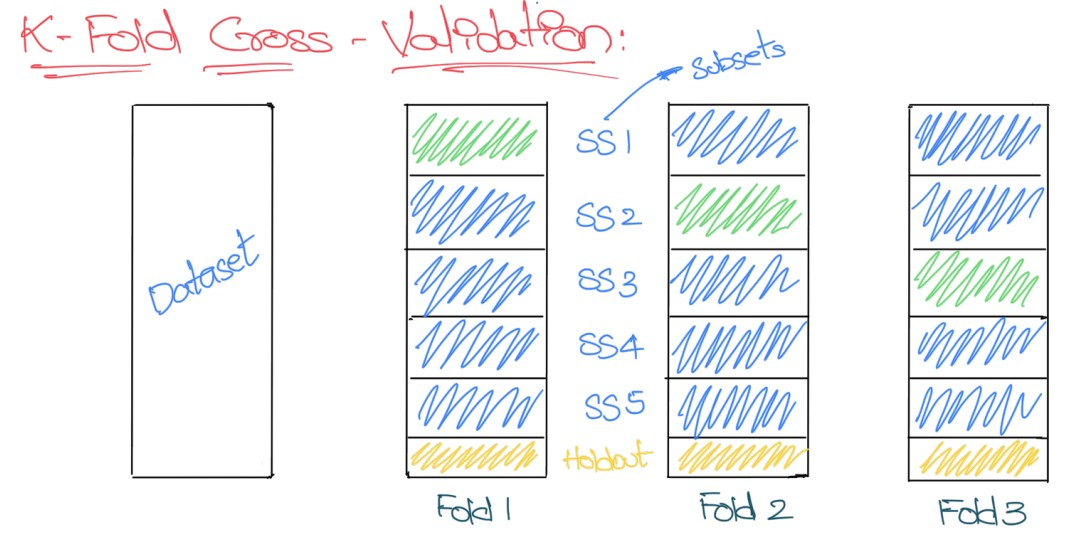

In [26]:
from IPython.display import Image, display
display(Image("cv.jpg"))

1. Dataset is split into K subsets.
2. The algorithm is then iterated K (fold) times and in each fold different subsets are used as a validation set (green ones)
3. This help us to determine the model's sensitivity to new and unseen data.
4. Finally a holdout/test set is used to evaluate the model.

**Let's gather different models from the library**

1. Why normalization.
2. Why splitting the data.

**Hands-on**

1. Add GB model for Hannes file. Take just the most important ones but GB at the beginning. Then, compare.
2. Try different K folders to see how it takes more computational time to solve. Also to check how accuracy changes.

In [42]:
# Load the Excel file again
df_experimental = pd.read_excel("/content/master.xlsx", sheet_name="experimental")

# Input and output split
X = df_experimental.iloc[:89, 1:12]
# In order to check wheter we have selected the appropiate columns, just:
print(X)
Y = df_experimental.iloc[:89, 12:]
print(Y)

# Normalize inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

X_train_full, X_holdout, Y_train_full, Y_holdout = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42, shuffle=True)

# Define models to test
base_models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "SVR (RBF Kernel)": SVR(kernel='rbf')
}


results_per_model = {}

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)  # Reduce repeats for speed if needed

# This is telling scikit-learn: split the data into 5 equal parts (aka 5 folds). Then train on 4 folds and validate on 1. Repeat this 5
# times, each time with a different random fold split. The random_state is just for reproducibility each time I run the code.

for name, model in base_models.items():
    print(f"Evaluating {name}...")
    multi_model = MultiOutputRegressor(model)
    r2_scores = []

    for train_idx, test_idx in rkf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[test_idx]
        Y_train, Y_val = Y_train_full[train_idx], Y_train_full[test_idx]

        multi_model.fit(X_train, Y_train)
        Y_pred = multi_model.predict(X_val)

        fold_r2 = r2_score(Y_val, Y_pred, multioutput='raw_values')  # List of R² for each output
        r2_scores.append(fold_r2)

    # Average R² per output
    r2_scores = np.array(r2_scores)
    avg_r2_per_output = np.mean(r2_scores, axis=0)
    results_per_model[name] = avg_r2_per_output

results_df = pd.DataFrame(results_per_model, index=Y.columns).T
results_df["Average R² Score"] = results_df.mean(axis=1)
#Sort
results_df.sort_values(by="Average R² Score", ascending=False, inplace=True)

# Save
results_df.to_csv("/content/models_performance_CV.csv", index=True)
print("Cross-validation results:")
print(results_df)

# Now we focus on the best performing model and test it using the holdout set from the first split
best_model_name = results_df.index[0]
print(f"Training {best_model_name} on full training set and evaluating on holdout...")

final_model = MultiOutputRegressor(base_models[best_model_name])
final_model.fit(X_train_full, Y_train_full)
Y_pred_holdout = final_model.predict(X_holdout)

holdout_r2 = r2_score(Y_holdout, Y_pred_holdout, multioutput='raw_values')
print(f"Holdout R² per output: {holdout_r2}")
print(f"Average Holdout R²: {np.mean(holdout_r2):.3f}")

         C  $H_{T1}$  $H_{T2}$   P       d  $\alpha$  Pearlite  $Cryo_{T}$  \
0   0.0014       920       830   4  0.0335      0.90      0.10        -125   
1   0.0014       940       810   4  0.0935      0.50      0.50         -75   
2   0.0014       920       790   4  0.0335      0.75      0.25        -125   
3   0.0020       880       830   4  0.0935      0.50      0.50        -125   
4   0.0014       900       830   2  0.0335      0.90      0.10        -100   
..     ...       ...       ...  ..     ...       ...       ...         ...   
82  0.0014       880       850   4  0.0935      0.75      0.25        -125   
83  0.0014       880       810  10  0.0935      0.50      0.50        -100   
84  0.0014       920       790   2  0.0935      0.50      0.50        -100   
85  0.0020       880       810  10  0.0635      0.50      0.50        -100   
86  0.0017       940       830   4  0.0935      0.90      0.10        -125   

    $Cryo_{t}$  $Temper_{T}$  $Temper_{t}$  
0         3600    

**Data Augmentation**

**Import necessary libraries:**

In [28]:
import random

In [29]:
#10000 synthetic input generation

# Define synthetic value ranges for each parameter
synthetic_values = {
    "C": [0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.0020],
    "$H_{T1}$": [880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940],
    "$H_{T2}$": [790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850],
    "P": [2, 2.5, 3, 3.5, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10],
    "d": [0.0335, 0.04, 0.0435, 0.05, 0.0535, 0.06, 0.0635, 0.07, 0.0735, 0.08, 0.0835, 0.09, 0.0935],
    "$\\alpha$": [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90],
    "Pearlite": [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50],
    "$Cryo_{T}$": [-75, -80, -85, -90, -95, -100, -105, -110, -115, -120, -125],
    "$Cryo_{t}$": [2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4250, 4500, 4800],
    "$Temper_{T}$": [150, 160, 175, 200, 210, 225, 230, 240, 245, 250],
    "$Temper_{t}$": [3600, 3800, 4200, 4500, 4800, 5400, 6000, 6300, 6600, 6900, 7200]
}

# Generate random combinations
random_combinations = []
while len(random_combinations) < 10000:  # Keep generating until we have 10000 valid combinations
    combination = {param: random.choice(values) for param, values in synthetic_values.items()}

    if combination["$\\alpha$"] + combination["Pearlite"] == 1:
        random_combinations.append(combination)

# Create DataFrame
synthetic_df = pd.DataFrame(random_combinations)

# Save to excel file or csv using .to_excel:
output_file=r'/content/Synthetic_inputs.csv'
synthetic_df.to_csv(output_file, index=False)

**GB model as the output generator for synthetic input data.**

1. Explain here the other way to split the data using **train_test_split**
2. Explain for what I am using the **original data** (training the model) and for what and how I am using the **new synthetic data**.

In [30]:
# Loading synthetic data for the 10000 predicted outputs
df_synthetic_10000=pd.read_csv(r'/content/Synthetic_inputs.csv').iloc[:10002, :11]
X_synth_10000 = df_synthetic_10000.copy()
X_synth_10000_scaled=scaler_X.transform(X_synth_10000)

ensemble_preds_10000_synthetic=[]
train_r2_scores=[]
test_r2_scores=[]

for i in range(42, 56):
    base_gb = GradientBoostingRegressor(random_state=i)
    gb = MultiOutputRegressor(base_gb)
    gb.fit(X_train, Y_train)

    preds_10000_synthetic=gb.predict(X_synth_10000_scaled)
    ensemble_preds_10000_synthetic.append(preds_10000_synthetic)

# Calculate mean (14 models, one for each random state=i) predictions for synthethic.
ensemble_preds_10000_synthetic=np.stack(ensemble_preds_10000_synthetic)
Y_10000_synth_mean=np.mean(ensemble_preds_10000_synthetic, axis=0)
Y_10000_synth_physical = scaler_Y.inverse_transform(Y_10000_synth_mean)


# Convertir a DataFrame
output_columns = df_experimental.columns[12:]

Y_10000_df=pd.DataFrame(Y_10000_synth_physical, columns=output_columns)
synthetic_10000_full_df=pd.concat([X_synth_10000.reset_index(drop=True), Y_10000_df], axis=1)

synthetic_10000_full_df.to_csv(r'/content/Synthetic_outputs.csv', index=False)

print("Saved successfully!")

Saved successfully!


**SHAP Sensitivity Analysis**

[Visit SHAP webpage HERE for more information](https://shap.readthedocs.io/en/)

**Import neccesary libraries:**


In [31]:
import shap

           C  $H_{T1}$  $H_{T2}$     P       d  $\alpha$  Pearlite  \
0     0.0018       925       805   7.5  0.0600      0.75      0.25   
1     0.0016       890       790  10.0  0.0800      0.60      0.40   
2     0.0018       905       820   3.0  0.0500      0.60      0.40   
3     0.0018       920       835   5.0  0.0535      0.70      0.30   
4     0.0018       940       815   9.0  0.0700      0.60      0.40   
...      ...       ...       ...   ...     ...       ...       ...   
9995  0.0017       890       830   6.0  0.0835      0.75      0.25   
9996  0.0015       940       810   7.0  0.0400      0.60      0.40   
9997  0.0016       915       840   8.0  0.0735      0.85      0.15   
9998  0.0017       890       845   2.0  0.0635      0.50      0.50   
9999  0.0019       895       795   8.0  0.0735      0.65      0.35   

      $Cryo_{T}$  $Cryo_{t}$  $Temper_{T}$  $Temper_{t}$  
0            -95        3200           175          4800  
1            -90        3000           16

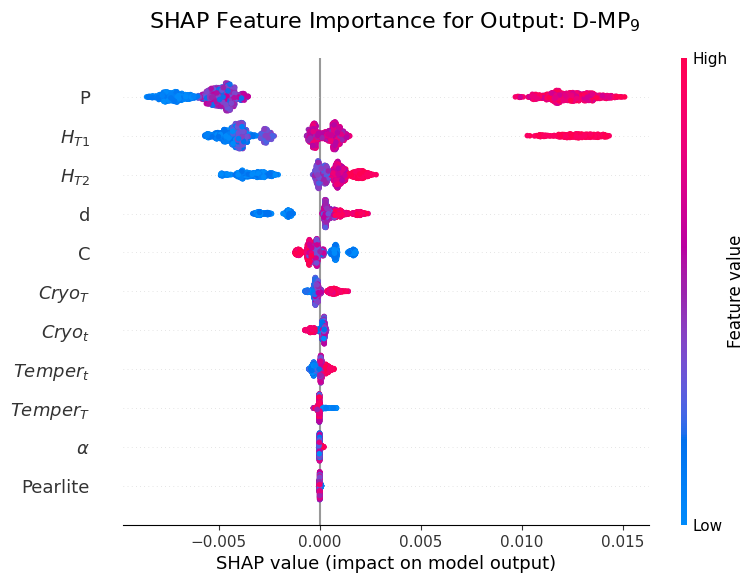

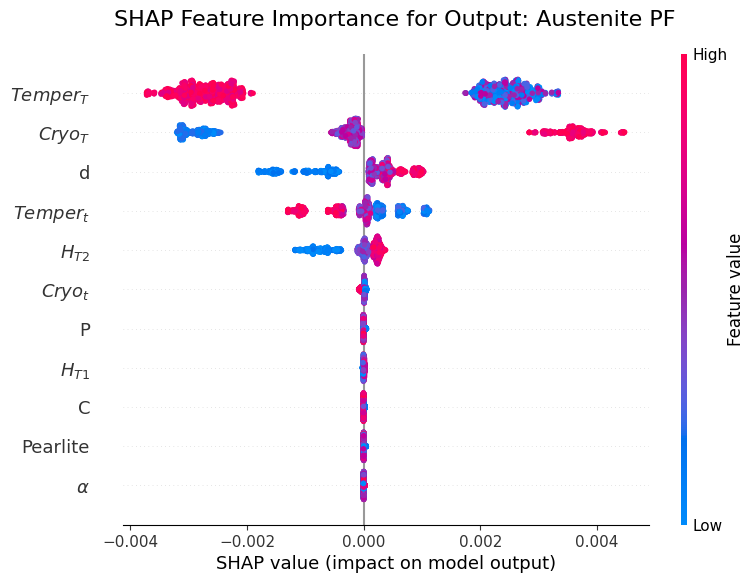

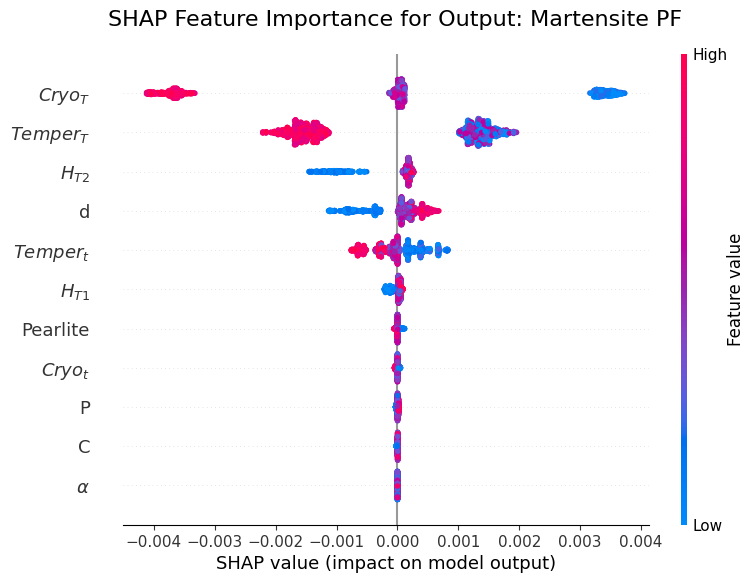

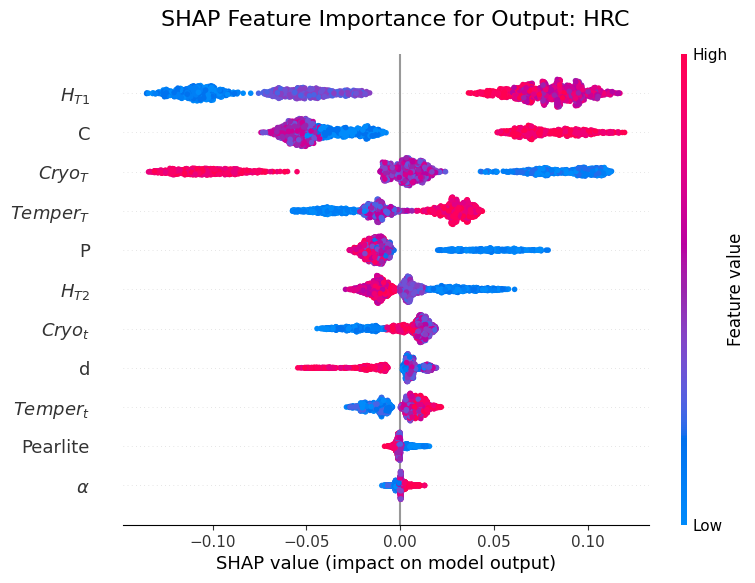

In [34]:
df_synthetic= pd.read_csv("/content/Synthetic_outputs.csv")

# Select input features and target output
X = df_synthetic.iloc[:10002, :11] # Adjust columns as needed (Input parameters)
print(X)

for i in range(19,23):
    Y = df_synthetic.iloc[:10002, i].values  # Choose the output you want to explain
    output_name=df_synthetic.columns[i]

    # Split into train and test for better modeling
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Train a Random Forest model
    model = GradientBoostingRegressor()
    model.fit(X_train, Y_train)

    # Create a SHAP explainer
    explainer = shap.Explainer(model, X_train)

    # Get SHAP values for the test set
    shap_values = explainer(X_test)

    # Visualize summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
    plt.suptitle(f"SHAP Feature Importance for Output: {output_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to make room for the title

    # Save if needed:
    # plt.savefig(f"SHAP_{output_name}_1000d.jpg", dpi=1000)

    plt.show()


**Simplified Model**

**Import necessary libraries:**

In [71]:
def evaluate_model_greedy_fast(X, Y, feature_list, test_size=0.2):
    results = []

    for i in range(1, len(feature_list) + 1):
        selected_features = feature_list[:i]
        X_subset = X[selected_features]

        # Repeated K-Fold cross-validation
        rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
        rkf_scores = []

        for train_idx, val_idx in rkf.split(X_subset):
            X_train, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
            Y_train, Y_val = Y.iloc[train_idx], Y.iloc[val_idx]

            model = GradientBoostingRegressor(random_state=42)
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_val)
            rkf_scores.append(r2_score(Y_val, Y_pred))

        avg_rkf_score = np.mean(rkf_scores)

        # Holdout test set evaluation
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_subset, Y, test_size=test_size, random_state=42, shuffle=True
        )
        model = GradientBoostingRegressor(random_state=42)
        model.fit(X_train, Y_train)
        Y_pred_holdout = model.predict(X_test)
        holdout_score = r2_score(Y_test, Y_pred_holdout)

        results.append({
            'Num Features': i,
            'Features Used': selected_features,
            'RepeatedKFold R²': avg_rkf_score,
            'Holdout R²': holdout_score
        })

    return pd.DataFrame(results)

# Run the faster evaluation
shap_ranked_features=['$H_{T1}$', 'C', '$Cryo_{T}$', '$Temper_{T}$', 'P', '$H_{T2}$', '$Cryo_{t}$', 'd', '$Temper_{t}$', 'Pearlite', '$\\alpha$']
evaluation_df_fast = evaluate_model_greedy_fast(X, df_experimental.loc[:, 'HRC'], shap_ranked_features)
print(evaluation_df_fast)

    Num Features                                      Features Used  \
0              1                                         [$H_{T1}$]   
1              2                                      [$H_{T1}$, C]   
2              3                          [$H_{T1}$, C, $Cryo_{T}$]   
3              4            [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$]   
4              5         [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P]   
5              6  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   
6              7  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   
7              8  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   
8              9  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   
9             10  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   
10            11  [$H_{T1}$, C, $Cryo_{T}$, $Temper_{T}$, P, $H_...   

    RepeatedKFold R²  Holdout R²  
0           0.123404    0.365230  
1           0.560275    0.753319  
2           0.782746    0.837980  
3      

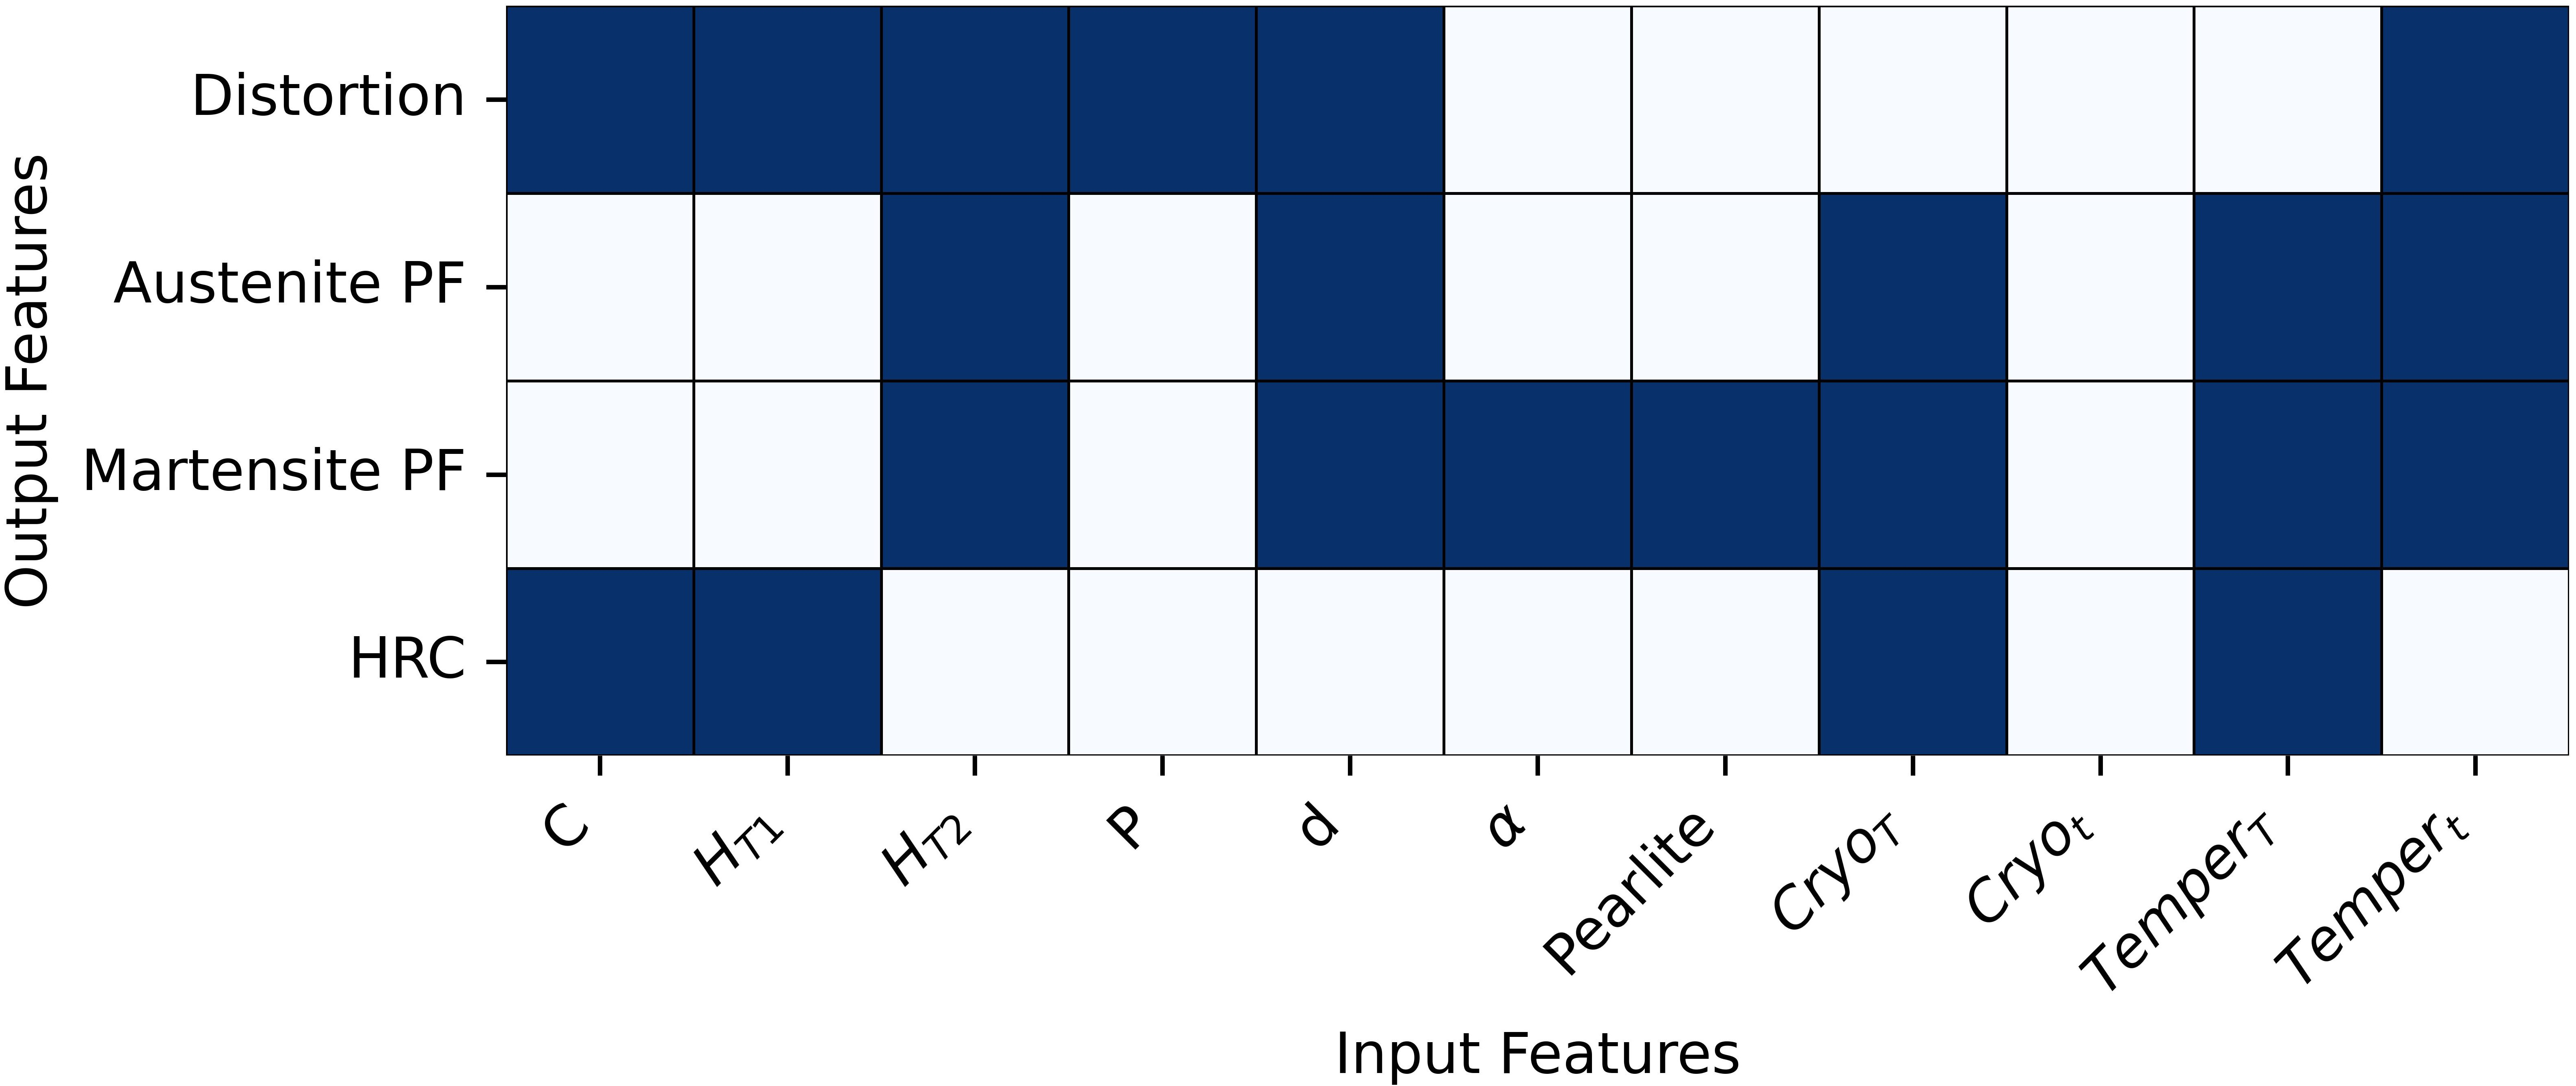

In [40]:
from IPython.display import Image, display
display(Image("selectionmatrixSM.jpg", width=800))


# Neural Networks Architectures
-------------------------------

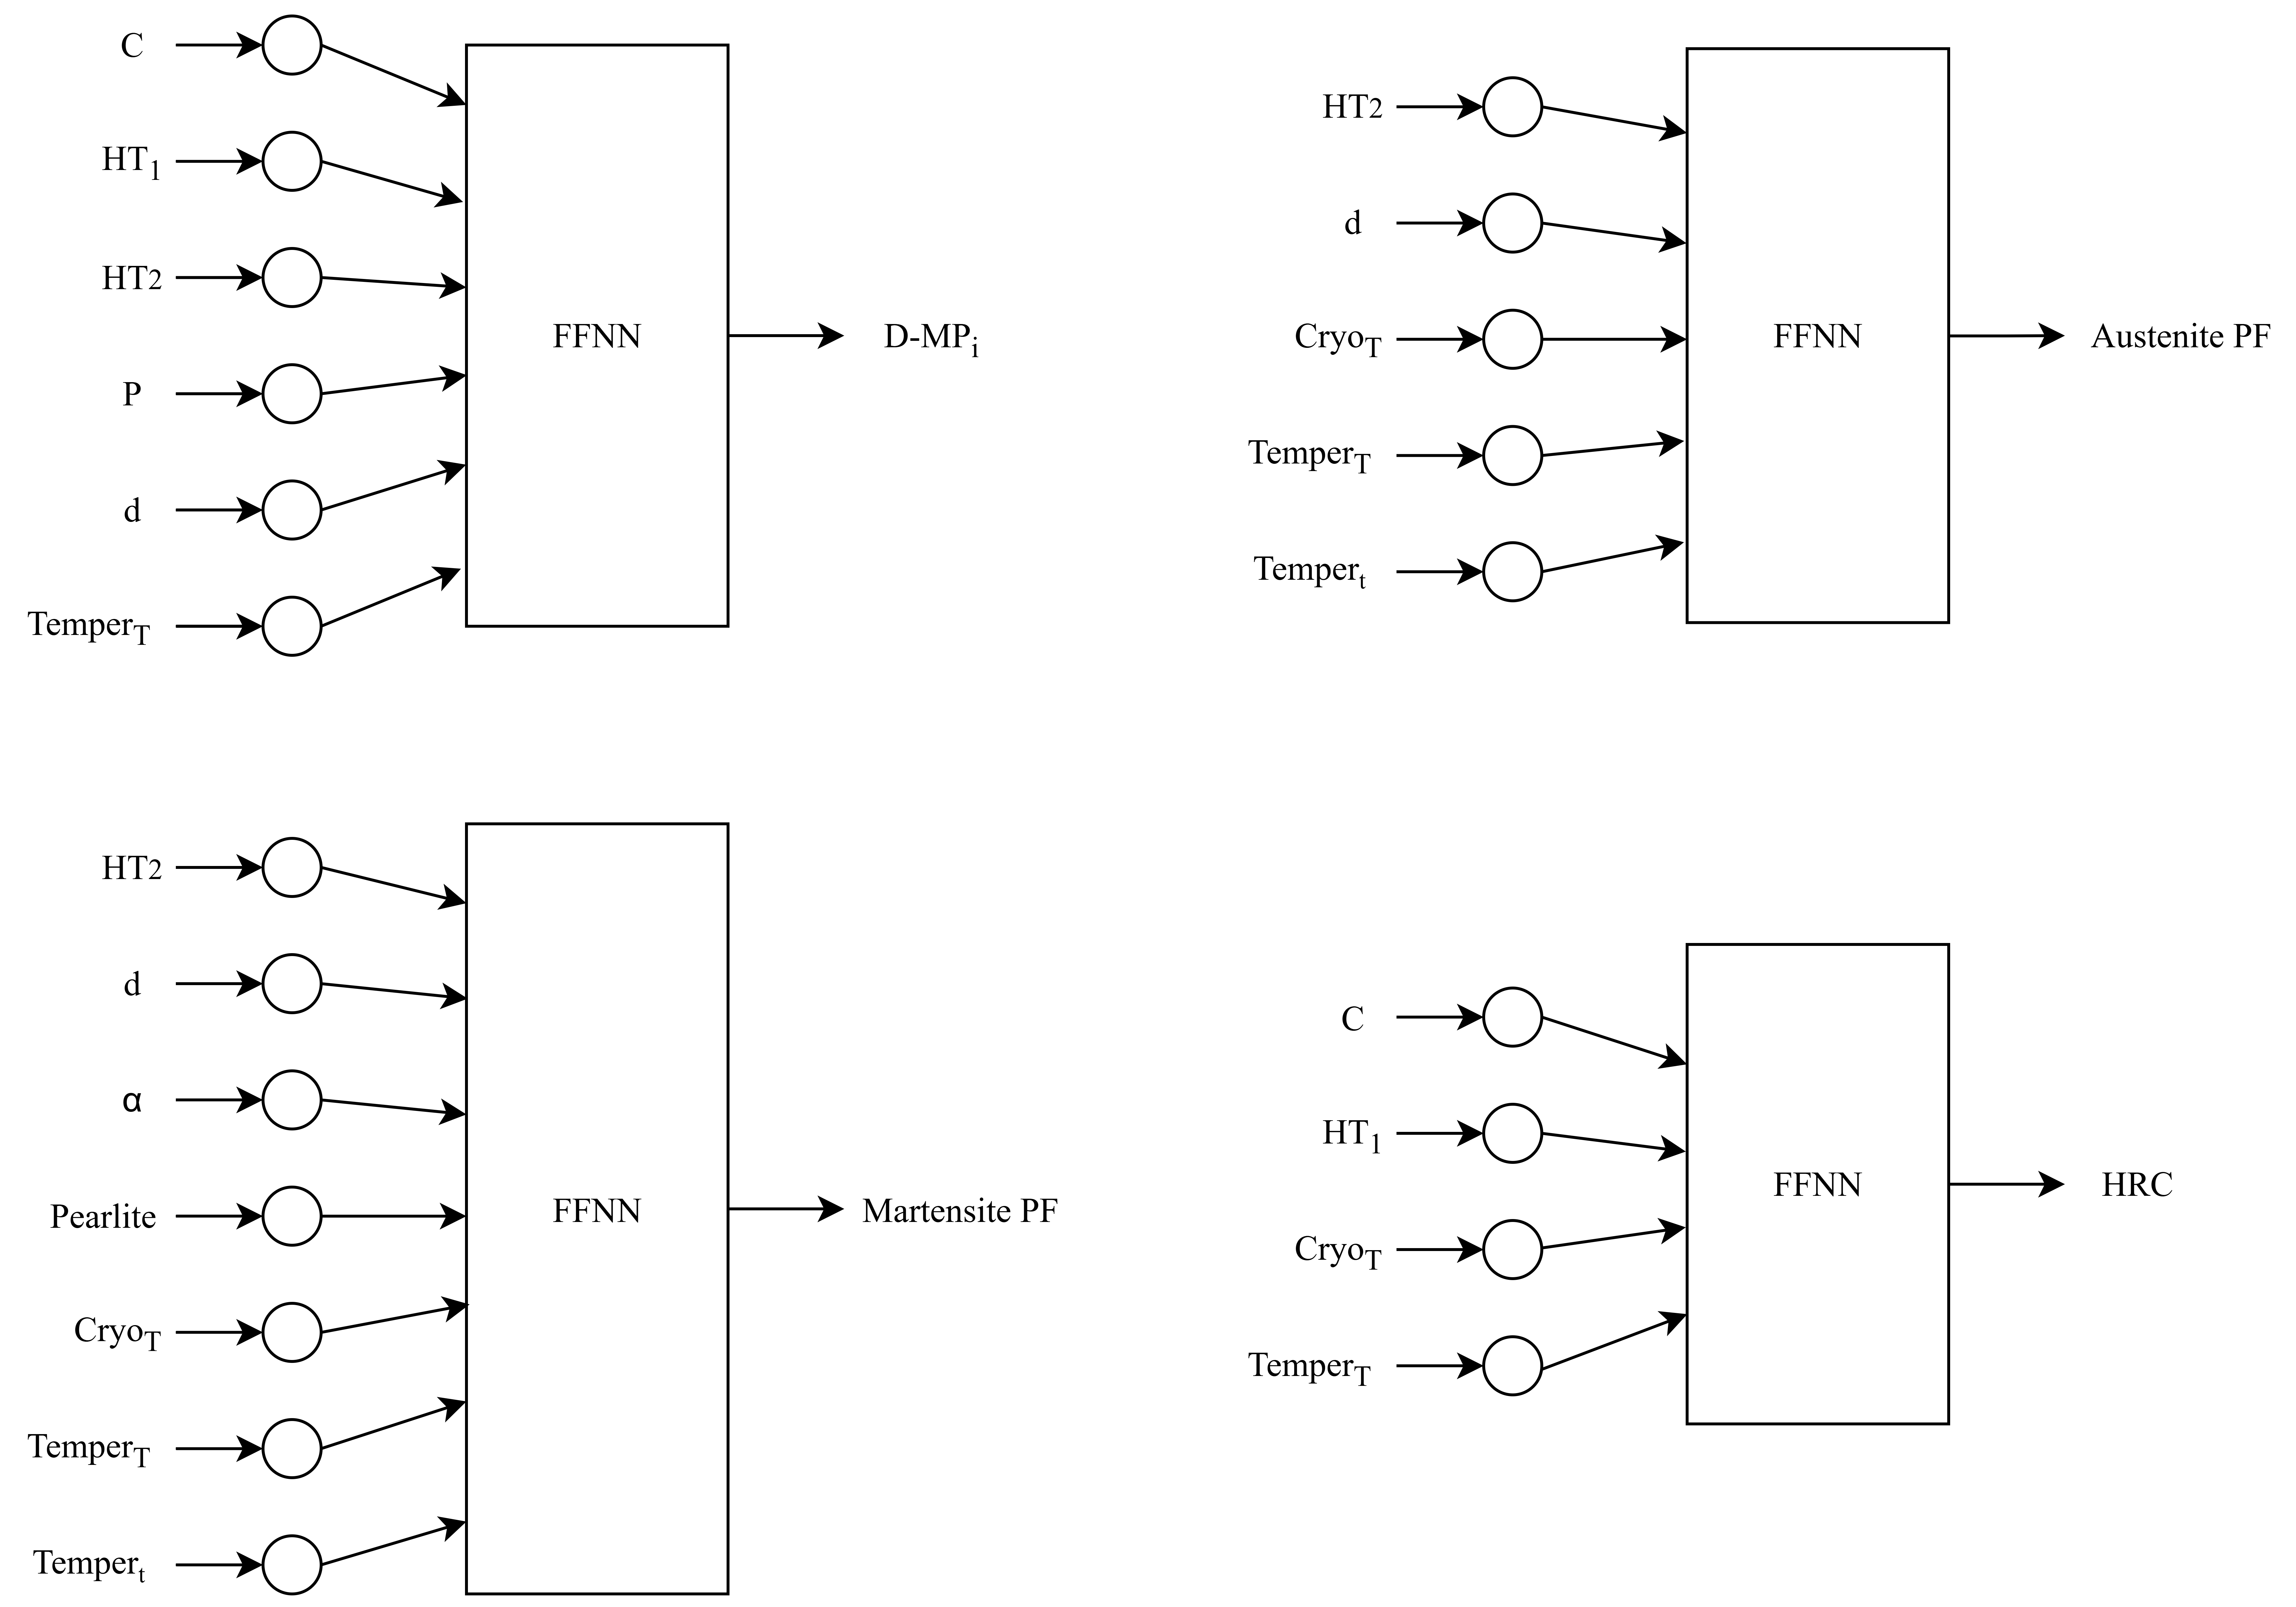

In [45]:
from IPython.display import Image, display
display(Image("ffnnnocascade.png", width=800))

**Import the necessary libraries:**

In [ ]:
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [73]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.7 MB/s eta 0:00:00


In [74]:
import optuna

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 6)
    units = trial.suggest_int("units", 64, 256)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))

    for _ in range(n_layers):
        model.add(layers.Dense(units, activation='relu'))

    model.add(layers.Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        ],
        verbose=0
    )

    Y_pred = model.predict(X_val).flatten()
    return r2_score(Y_val, Y_pred)

X= df_synthetic.iloc[:10002, [0, 1, 7, 9]]
print(X)
Y= df_synthetic.iloc[:10002, [22]] #Just for HRC
print(Y)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


# 1. Full split (train+val vs test)
X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=17, shuffle=True)

# 2. Split X_temp into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=17, shuffle=True)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

study.best_params

[I 2025-10-06 23:40:14,236] A new study created in memory with name: no-name-2c0c089b-cc89-4f4a-b2bc-95f7d36715f4


           C  $H_{T1}$  $Cryo_{T}$  $Temper_{T}$
0     0.0018       925         -95           175
1     0.0016       890         -90           160
2     0.0018       905         -90           250
3     0.0018       920         -95           210
4     0.0018       940        -110           175
...      ...       ...         ...           ...
9995  0.0017       890         -80           175
9996  0.0015       940        -120           210
9997  0.0016       915         -90           245
9998  0.0017       890         -95           210
9999  0.0019       895         -85           160

[10000 rows x 4 columns]
            HRC
0     64.400369
1     64.255488
2     64.363577
3     64.402655
4     64.312446
...         ...
9995  64.022990
9996  64.447914
9997  64.379993
9998  64.223369
9999  64.365158

[10000 rows x 1 columns]


In [ ]:
model = keras.Sequential([
    layers.Dense(139, activation='relu', input_shape=(X.shape[1],)),
    layers.Dense(139, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)  # no activation (regression)
])

optimizer = Adam(learning_rate=0.0032)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

start_train_time=time.time()
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=16,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ],
    verbose=1
)
end_train_time=time.time()

mse, mse = model.evaluate(X_val, Y_val)
print(f"Validation MSE: {mse:.4f}")


# Optional: R² score
from sklearn.metrics import r2_score

start_pred_train=time.time()
Y_pred_train=model.predict(X_temp).flatten()
end_pred_train=time.time()

start_pred_test=time.time()
Y_pred_test = model.predict(X_test).flatten()
end_pred_test=time.time()

r2 = r2_score(Y_test, Y_pred_test)
print(f"R² score: {r2:.4f}")

Y_pred_train_physical=scaler_Y.inverse_transform(Y_pred_train.reshape(-1,1)).flatten()
Y_pred_test_physical=scaler_Y.inverse_transform(Y_pred_test.reshape(-1,1)).flatten()
Y_pred_physical_all=np.concatenate([Y_pred_train_physical, Y_pred_test_physical])
Y_pred_physical_df=pd.DataFrame(Y_pred_physical_all, columns=["Hardness_NN_pred"])

Y_train_physical=scaler_Y.inverse_transform(Y_temp.reshape(-1,1)).flatten()
Y_test_physical=scaler_Y.inverse_transform(Y_test.reshape(-1,1)).flatten()

print(Y_train_physical.shape)
print(Y_pred_train_physical.shape)
print(Y_test_physical.shape)
print(Y_pred_test_physical.shape)

# Train predictions
plt.scatter(Y_train_physical, Y_pred_train_physical, alpha=0.4, label='Train Designs', color='royalblue')

# Test predictions
plt.scatter(Y_test_physical, Y_pred_test_physical, alpha=0.6, label='Test Designs', color='orange')

# Add y = x line (perfect prediction)
min_val = min(min(Y_test_physical), min(Y_pred_test_physical))
max_val = max(max(Y_test_physical), max(Y_pred_test_physical))

plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("True HRC")
plt.ylabel("Predicted HRC")
plt.title(f"Hardness Prediction (No Cascade) — R² = {r2:.4f}")
plt.legend()
plt.grid(True)
#plt.savefig('HRC_Prediction_WITHOUT_Cascade_2_139_Dropout_02.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Plot MSE vs. Epochs
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss for HRC (No Cascade)')
plt.legend()
plt.grid(True)
#plt.savefig('HRC_Loss_comparison_WITHOUT_Cascade_2_139_Dropout_02.jpg', dpi=300, bbox_inches='tight')
plt.show()

#print(f"Training time: {(end_train_time - start_train_time):.5f} seconds")
#print(f"Train prediction time: {(end_pred_train - start_pred_train):.5f} seconds")
#print(f"Test prediction time: {(end_pred_test - start_pred_test):.5f} seconds")

# Guardar en la hoja "synthetic"
#with pd.ExcelWriter("D:/THESIS/OUTPUTS/master.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
      #Y_pred_physical_df.to_excel(writer, sheet_name="Hardness_FFNN", index=False)

print("Saved successfully!")